## Part 0: Data Processing and EDA

### Process and High Level Findings

Our first step when handed the data was to visualize some of the variables and see if there are some predictors that might prove to be very impactful in determining the star rating for a particular restaurant. After taking a brief look at the various variables stored in the various json files, we decided to take a random walk through some predictors we belived would be impactful to star rating. While some of our findings at times weren't particularly interesting, some predictors did stick out from the rest in predicting a restaurant's rating.

The presence of a drive-thru, for example, dropped the average star rating by 0.71. The state of California has significantly higher ratings than any other US state in the dataset, and average star rating consistently increases as the price range increases. Lengthier reviews will tend to have lower ratings than shorter ones, and the longer a particular user has been elite, the lower the average star rating will be.

In the notebook below we have various of the visualizations that led us to the broad generalizations above, plus a few more, all with a subsequent explanation. 

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from random import *
from math import log
from pandas.io.json import json_normalize
import copy
pd.set_option('display.max_columns', None)

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  
# preprocessed review file with reviews only for restaurants 
with open('dataset/restaurant_reviews_trimmed.json') as f:
    review_data = [json.loads(line) for line in f]

# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

# convert array to list
restaurant_reviews = review_data[0]


### EDA

In [3]:
restaurant_df = json_normalize(restaurant_data)

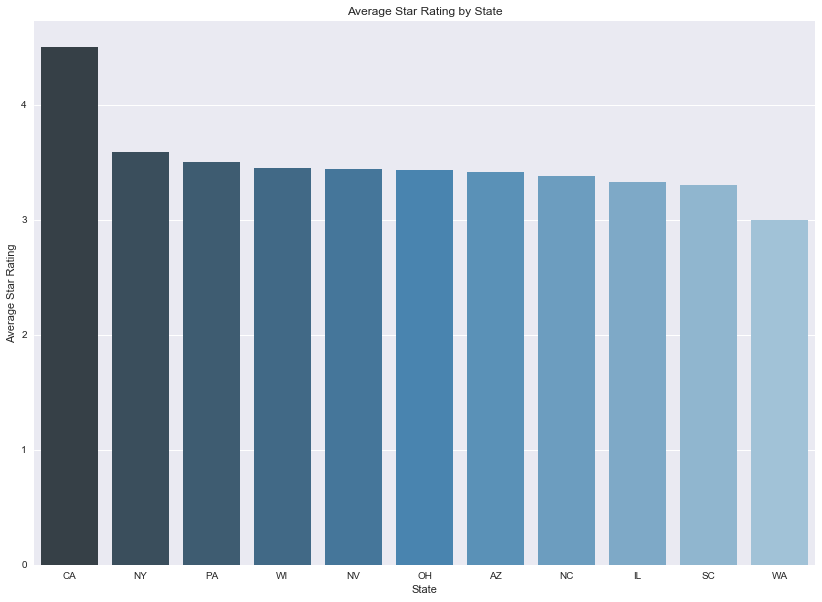

In [4]:
statemeans_df = restaurant_df.groupby('state', as_index=False)['stars'].mean()
statemeans_df = statemeans_df.sort_values(by=['stars'], ascending=False)
states = [ "AK","AL","AR","AS","AZ","CA","CO","CT","DC","DE","FL","GA","GU","HI","IA","ID","IL","IN",
"KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY","OH",
"OK","OR","PA","PR","RI","SC","SD","TN","TX","UT","VA","VI","VT","WA","WI","WV","WY"]
statemeans_df = statemeans_df[statemeans_df['state'].isin(states)]
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x='state',y='stars',palette="Blues_d", data=statemeans_df)
ax.set_ylabel('Average Star Rating');
ax.set_title('Average Star Rating by State');
ax.set_xlabel('State');

**Average Restaurant Rating by State:** California seems to have a significantly higher average star rating than any other US state in the dataset. With the exception of Washington which has a sizeable dip, all other states are close to the same rating


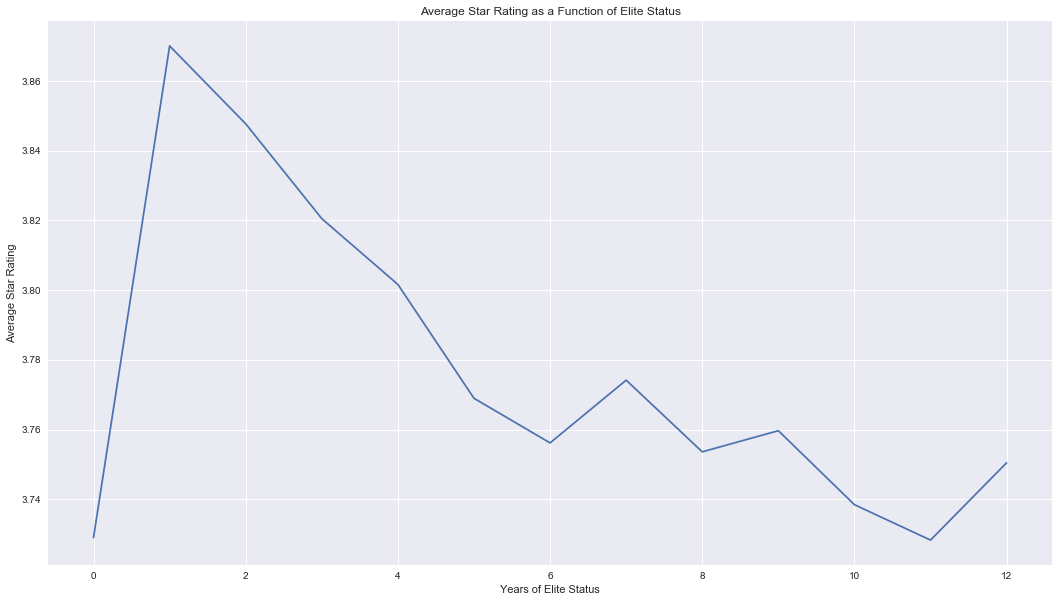

In [6]:
elite_dict = {}

for x in range(int(len(user_data)/20)):
    elite_dict[len(user_data[x]['elite'])] = []

for x in range(int(len(user_data)/20)):
    elite_dict[len(user_data[x]['elite'])].append(user_data[x]['average_stars'])

trash_keys = []
for x in elite_dict:
    if len(elite_dict[x]) <= 5:
        trash_keys.append(x)
    else:
        elite_dict[x] = np.mean(elite_dict[x])
for x in trash_keys:
    del elite_dict[x]

pairs = zip(list(elite_dict.keys()), list(elite_dict.values()))
pairs = sorted(pairs, key=lambda x: x[0], reverse=False)
elite, means = zip(*pairs)

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(elite, means);
ax.set_xlabel('Years of Elite Status');
ax.set_ylabel('Average Star Rating');
ax.set_title('Average Star Rating as a Function of Elite Status');

** Average Star Rating by Elite Status Length:** Plotting the average user rating as a function of how long the user has held elite status seems to show a negative linear relationship. This might indicate that elite users might become more critial over time, with people who have yet to become elits leaving the harshest reviews

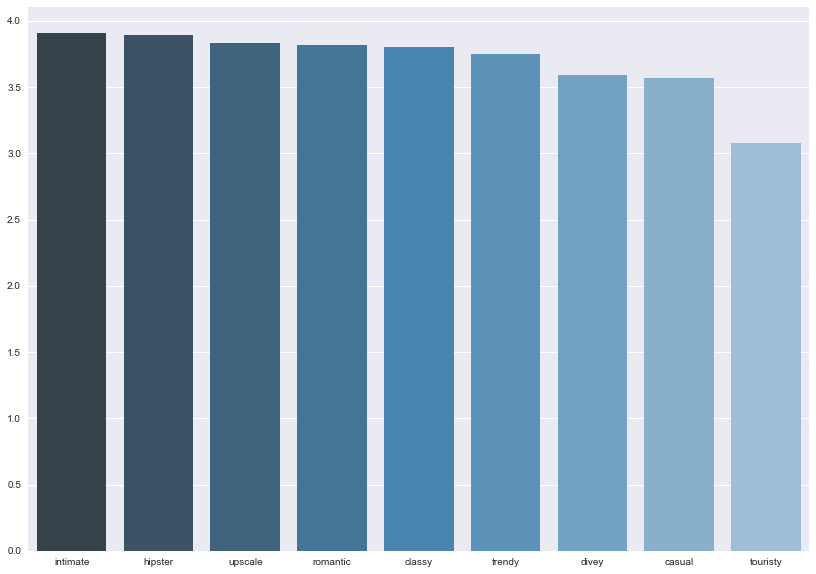

In [7]:
ambience_headers=restaurant_df.columns[4:13].values
ambience_dict = {}

for item in ambience_headers:
    trimmed_name = item[20:]
    ambience_dict[trimmed_name] = restaurant_df.loc[restaurant_df[item] == True, 'stars'].mean()

pairs = zip(list(ambience_dict.keys()), list(ambience_dict.values()))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
ambiences, means = zip(*pairs)
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x=ambiences, y=means, palette='Blues_d')

** Ambience's Effect on Star Rating:** It appears that even the restaurant ambience can have an impact on restaurant rating. From a high level intimate restaurants have the highest ratings, with most other ambiences following close behind. Interesting to note was the ambience touristy, which could be because tourist traps usually serve subpar food at inflated prices (based on personal experiences).  

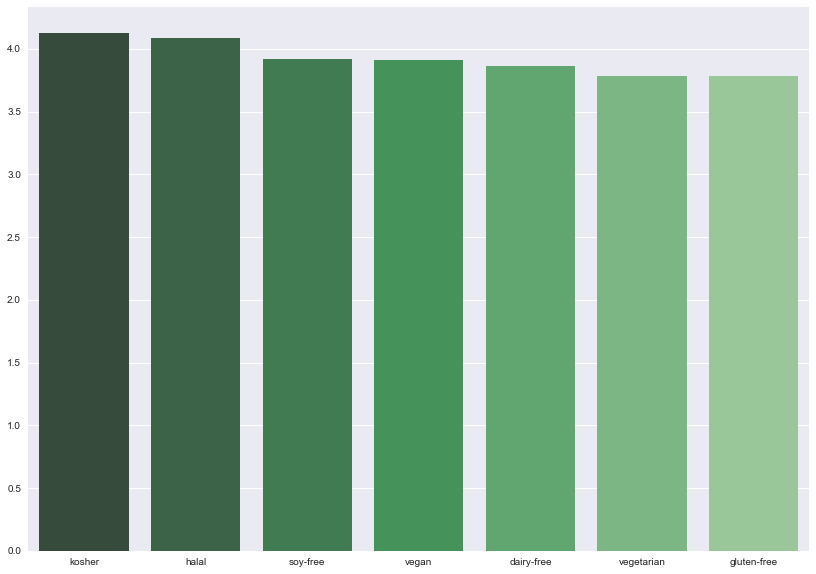

In [8]:
dietary_headers = restaurant_df.columns[34:41]
dietary_dict={}

for item in dietary_headers:
    trimmed_name = item[31:]
    dietary_dict[trimmed_name] = restaurant_df.loc[restaurant_df[item] == True, 'stars'].mean()

pairs = zip(list(dietary_dict.keys()), list(dietary_dict.values()))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
dietaryrestrictions, means = zip(*pairs)
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x=dietaryrestrictions, y=means, palette='Greens_d')

** Average Star Rating by  Dietary Restrictions: ** Trying to see if dietary restrictions had any impact on the outcome, we plotted average star ratings by restrictions. It seems that there are slight differences in star rating among restrictions, with restaurants that cater to more restrictive diets like kosher, halal, and vegan faring better than others. 

In [9]:
def create_pivot_restaurant(df, cat):
    sub_df = df[[cat,'stars']]
    pivot = pd.pivot_table(sub_df,index=[cat], aggfunc=np.sum) 
    pivot['TOTAL_COUNT'] = sub_df[cat].value_counts() 
    pivot['AVG_RATING'] = pivot['stars']/pivot['TOTAL_COUNT'] 
    return pivot

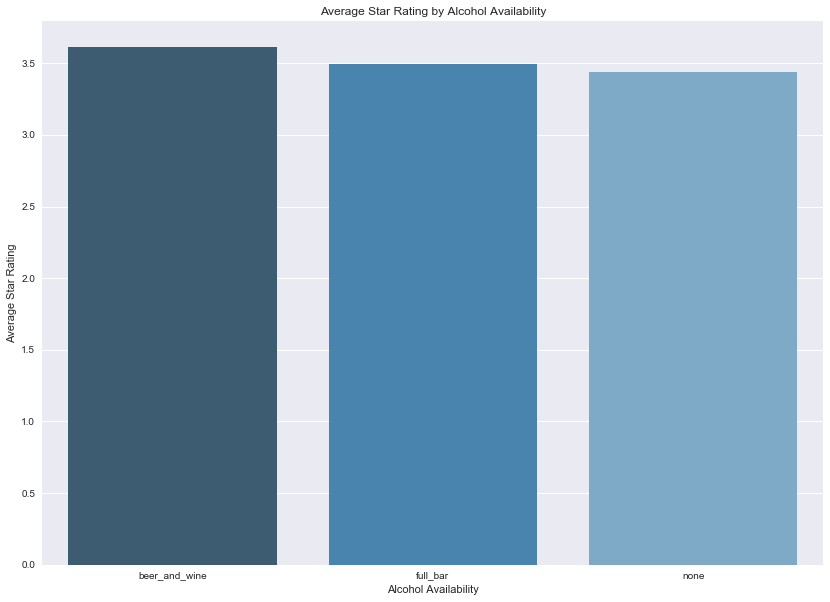

In [10]:
d = create_pivot_restaurant(restaurant_df, 'attributes.Alcohol')
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(d.index, d['AVG_RATING'], ax = ax, palette = 'Blues_d')
ax.set_xlabel("Alcohol Availability")
ax.set_ylabel('Average Star Rating')
ax.set_title('Average Star Rating by Alcohol Availability');

** Alcohol Availability on Star Rating: ** It seems that people love a good drink when they go to a restaurant. Restaurants with no alcohol performed the worst when measured on the star-rating, and restaurants with a great beer and wine selection perform the best

In [11]:
restaurant_df_v2 = restaurant_df
d = create_pivot_restaurant(restaurant_df, 'attributes.RestaurantsAttire')
d

,stars,TOTAL_COUNT,AVG_RATING
attributes.RestaurantsAttire,,,
casual,149545.5,43276,3.455622
dressy,5207.0,1397,3.727273
formal,413.5,125,3.308000


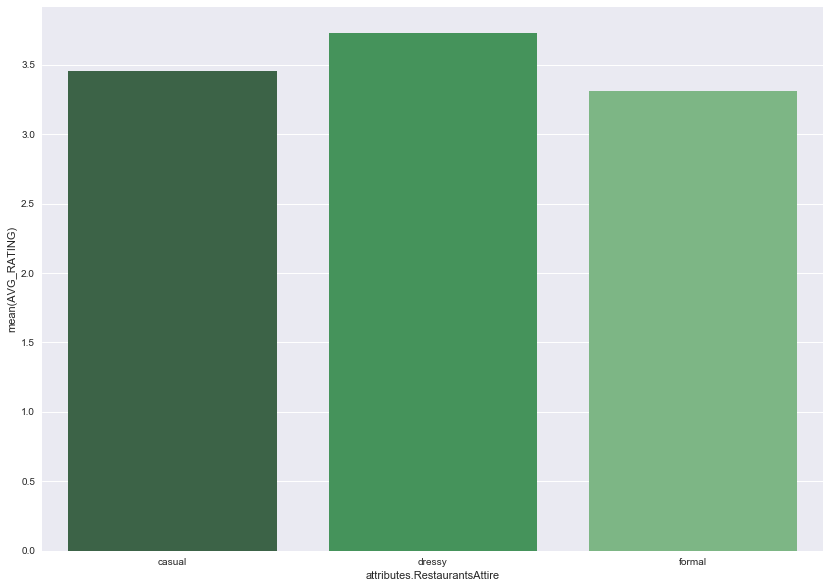

In [24]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(d.index, d['AVG_RATING'], ax = ax, palette='Greens_d')

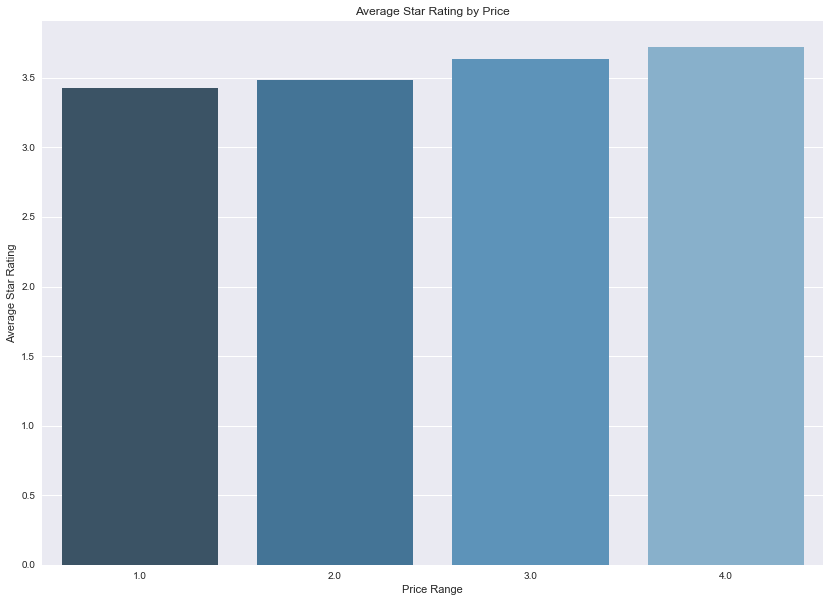

In [23]:
r = create_pivot_restaurant(restaurant_df, 'attributes.RestaurantsPriceRange2')
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(r.index, r['AVG_RATING'], ax = ax, palette='Blues_d');
ax.set_xlabel("Price Range")
ax.set_ylabel("Average Star Rating")
ax.set_title("Average Star Rating by Price");

In [14]:
parking_ratings = {}
for a in ['attributes.BusinessParking.garage', 'attributes.BusinessParking.lot', 'attributes.BusinessParking.street',
          'attributes.BusinessParking.valet', 'attributes.BusinessParking.validated']:
    parking_ratings[a] =  create_pivot_restaurant(restaurant_df_v2, a).iloc[1]
parking_df = pd.DataFrame.from_dict(parking_ratings, orient = 'index')
parking_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.BusinessParking.garage,7593.5,2171.0,3.497697
attributes.BusinessParking.lot,58328.0,16437.0,3.548579
attributes.BusinessParking.street,32030.5,8676.0,3.691851
attributes.BusinessParking.valet,3769.5,1039.0,3.628008
attributes.BusinessParking.validated,862.5,238.0,3.623950


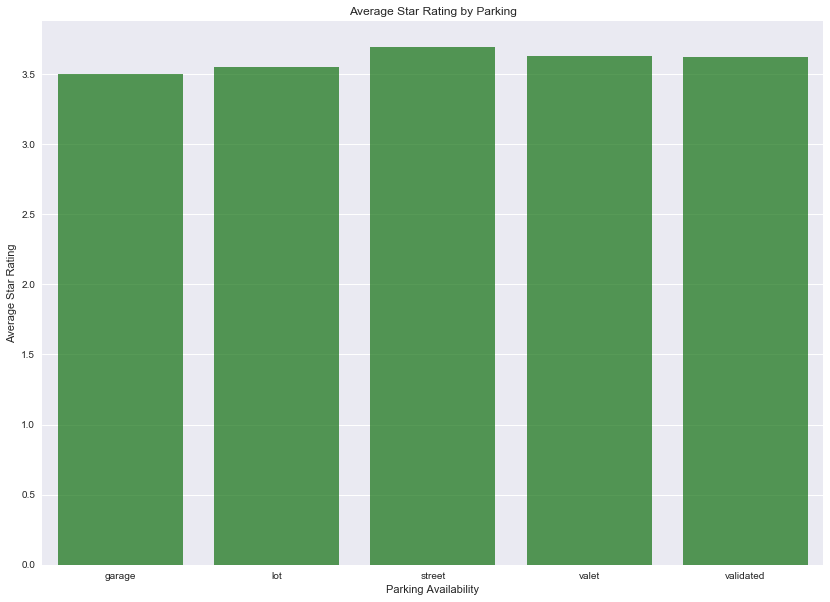

In [31]:
parking_ratings = {}
for a in ['attributes.BusinessParking.garage', 'attributes.BusinessParking.lot', 'attributes.BusinessParking.street',
          'attributes.BusinessParking.valet', 'attributes.BusinessParking.validated']:
    parking_ratings[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]
parking_df = pd.DataFrame.from_dict(parking_ratings, orient = 'index')
fig, ax = plt.subplots(figsize=(14,10))
index = [x.split('.')[2] for x in parking_df.index]
ax = sns.barplot(index, parking_df['AVG_RATING'], ax = ax, color='Green', alpha=0.7);

ax.set_xlabel("Parking Availability")
ax.set_ylabel("Average Star Rating")
ax.set_title("Average Star Rating by Parking");

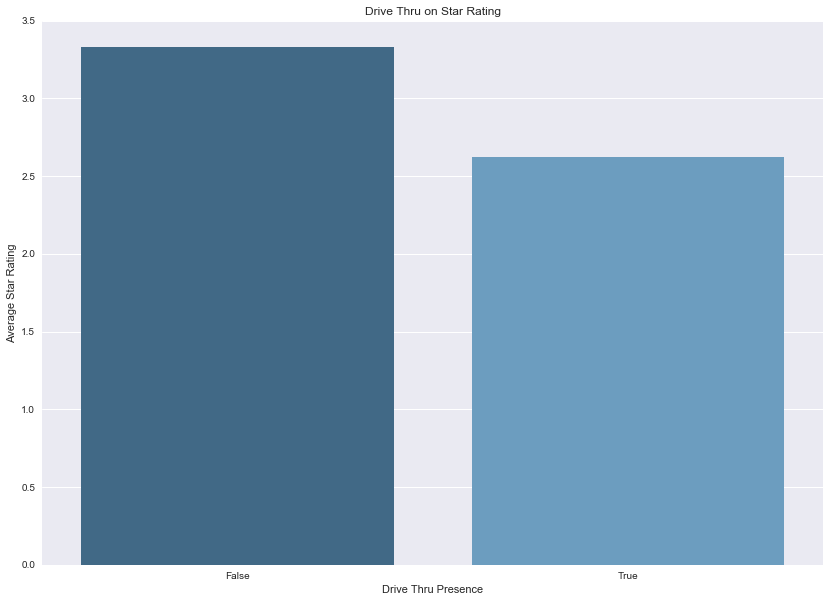

In [16]:
drivethru = create_pivot_restaurant(restaurant_df, 'attributes.DriveThru')
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(drivethru.index, drivethru['AVG_RATING'], palette='Blues_d')
ax.set_title("Drive Thru on Star Rating")
ax.set_xlabel('Drive Thru Presence')
ax.set_ylabel('Average Star Rating');

** Drive Thru Presence on Rating:**  Though simple, this bar graph shows a very sizeable difference in restaurant ratings depending on the presence of a drive thru. Restaurants with a drive thru are receiving significantly lower ratings than restaurants that do not. This makes sense intuitively, since many restaurants with drive thru's are fast food joints not known for fine cuisine. 

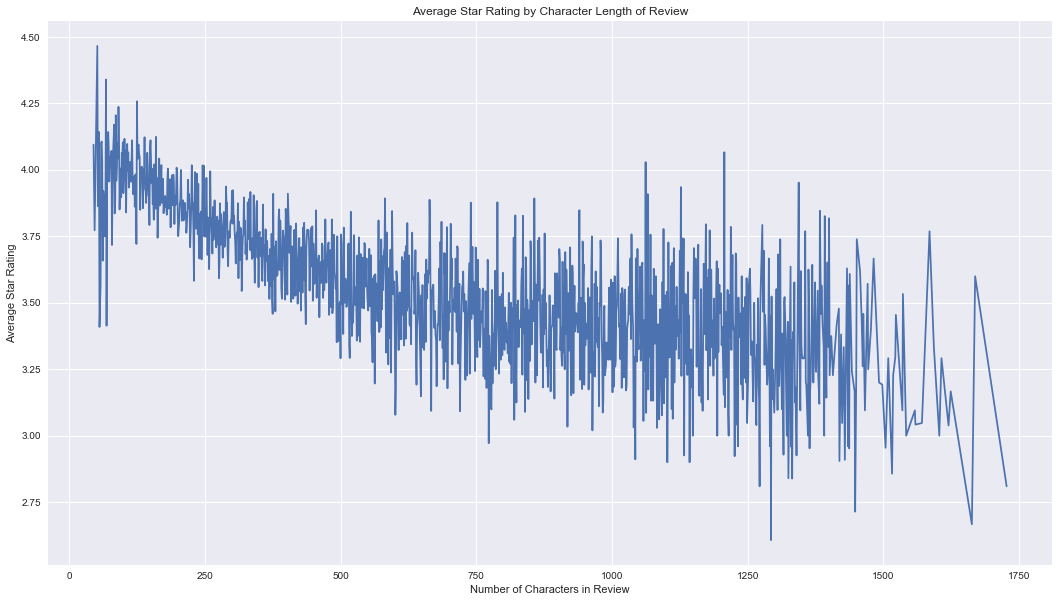

In [17]:
lengths_dict = {}

for x in range(int(len(restaurant_reviews)/20)):
    lengths_dict[len(restaurant_reviews[x]['text'])] = []

for x in range(int(len(restaurant_reviews)/20)):
    lengths_dict[len(restaurant_reviews[x]['text'])].append(restaurant_reviews[x]['stars'])

trash_keys = []
for x in lengths_dict:
    if len(lengths_dict[x]) <= 20:
        trash_keys.append(x)
    else:
        lengths_dict[x] = np.mean(lengths_dict[x])
for x in trash_keys:
    del lengths_dict[x]

pairs = zip(list(lengths_dict.keys()), list(lengths_dict.values()))
pairs = sorted(pairs, key=lambda x: x[0], reverse=False)
lengths, means = zip(*pairs)

fig, ax = plt.subplots(figsize=(18,10))
ax.plot(lengths, means)
ax.set_title("Average Star Rating by Character Length of Review");
ax.set_xlabel("Number of Characters in Review");
ax.set_ylabel("Average Star Rating");

** Average Star Rating by Number of Characters in Review:** When plotting against the number of characers left in the review, is appears that the average star rating decreases as the number of characters increases. This would seem to suggest that people who were very upset with their experience with a restaurant leave lengthier reviews to talk about everything that went wrong in their trip. 

/Users/PeterAyala/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


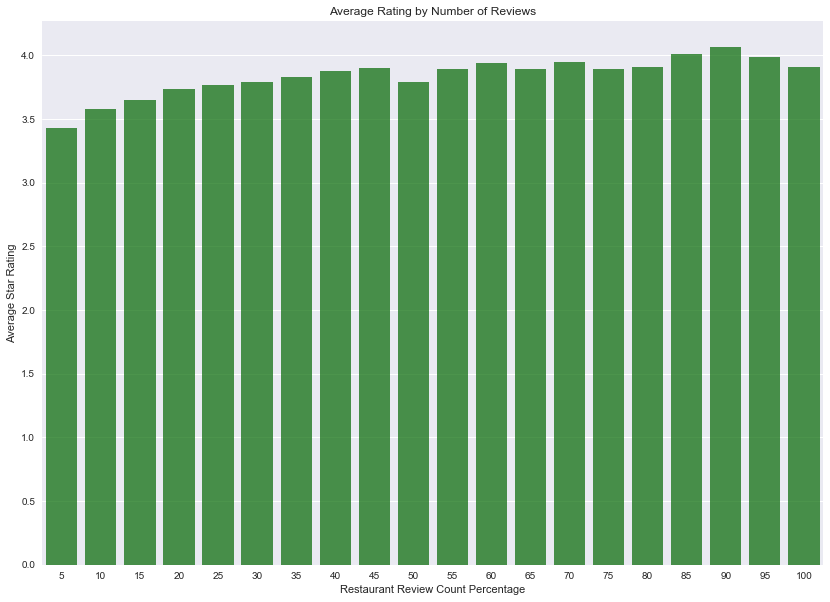

In [25]:
numbermeans_df = restaurant_df.groupby('review_count', as_index=False)['stars'].mean()
#plt.plot(numbermeans_df['review_count'], numbermeans_df['stars'])

slices = np.linspace(0, len(numbermeans_df), len(numbermeans_df)/45+1, True).astype(np.int)
counts = np.diff(slices)
mean = np.add.reduceat(numbermeans_df['stars'], slices[:-1]) / counts
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x=[x*10 for x in range(len(mean))], y=mean, color = 'green', alpha=0.75)
ax.set(xticklabels = [(x+1)*5 for x in range(21)]);
ax.set_title("Average Rating by Number of Reviews");
ax.set_xlabel("Restaurant Review Count Percentage");
ax.set_ylabel("Average Star Rating");

**Average Star Rating by Relative Number of Review:** Interested in seeing if resturants that had more reviews also had a higher average star rating, it seems that there is an ever so slight increase in average star rating the more reviews a particular restaurant has. The above bars represent 5% bins of the data. 